<a href="https://colab.research.google.com/github/JuttigaGowtham/FMML-22B21A4451/blob/main/FMML_Module_9_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 9: Convolutional Neural Networks
## **Lab 4**
### Module coordinator: Kushagra Agarwal

<img src="https://miro.medium.com/max/1200/1*QoqNAg2t6lF8Q6WWA6AbOg.png" width=650px/>

## Using learnt representations
In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.


We'll train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.




In [1]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import time
import os

In [2]:
# Device configuration (whether to run on GPU or CPU)
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Download and extract dataset
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -q hymenoptera_data.zip

--2024-05-07 13:20:16--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.172.170.53, 18.172.170.43, 18.172.170.8, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.172.170.53|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   229MB/s    in 0.2s    

2024-05-07 13:20:16 (229 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = './hymenoptera_data'
train_dataset = ImageFolder(os.path.join(data_dir, 'train'), train_transform)
val_dataset = ImageFolder(os.path.join(data_dir, 'val'), val_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4,shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=4,shuffle=True, num_workers=2)
class_names = train_dataset.classes


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


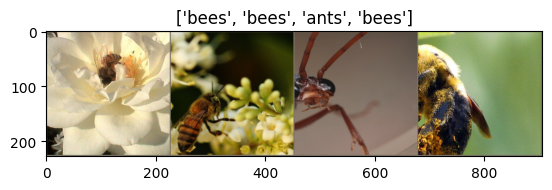

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, train_dataloader, criterion, optimizer, num_epochs=25):

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              # backward + optimize only if in training phase
              loss.backward()
              optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

In [7]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
from torchvision import models

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

loss_func = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 118MB/s]


In [9]:
num_epochs = 5
train_model(model_ft, train_dataloader, loss_func, optimizer, num_epochs)

Epoch 0/4
----------
Loss: 0.6011 Acc: 0.7213

Epoch 1/4
----------
Loss: 0.6347 Acc: 0.7828

Epoch 2/4
----------
Loss: 0.6429 Acc: 0.7746

Epoch 3/4
----------
Loss: 0.6131 Acc: 0.7787

Epoch 4/4
----------
Loss: 0.5187 Acc: 0.7623



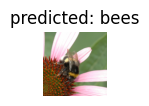

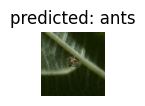

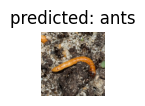

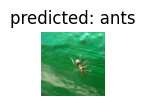

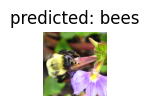

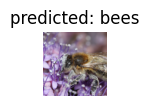

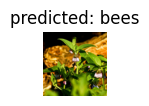

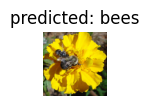

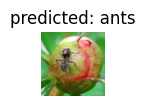

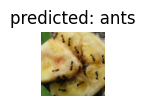

In [10]:
visualize_model(model_ft)

## Example of How Pretrained models are used for Target Tasks

<img src="https://www.researchgate.net/publication/340225334/figure/fig2/AS:960014822944773@1605896778155/Mechanism-of-transfer-learning-using-pre-trained-models.png" width=950px/>

## Questions:
1) What is the significance of using data augmentations like resize, crop etc on training data?

2) What performance do you get if you don't use pretrained resnet model (Hint: Change pretrained=False and train the model)

3) If the resnet model was pre-trained on dataset significantly different than the ants vs bees data, would you still get good performance by using this pretrained model?


**QUESTION 1**


Data augmentation techniques like resizing, cropping, rotating, flipping, and adding noise to training data serve several significant purposes in machine learning and deep learning:

Increase dataset size: Data augmentation effectively expands the dataset by creating variations of existing data. This helps prevent overfitting, where a model learns to memorize the training data rather than generalize from it. By introducing variations, the model learns to be more robust and generalizable.
Regularization: Augmentation acts as a form of regularization by adding noise to the input data during training. This helps in preventing the model from fitting the training data too closely and encourages it to learn the underlying patterns.
Translation invariance: Techniques like cropping and rotation help the model become invariant to translations and rotations in the input data. For example, a classifier trained on images should ideally recognize objects regardless of their position or orientation within the image.
Improving generalization: Data augmentation helps in capturing the underlying patterns of the data more effectively by exposing the model to a wider range of variations. This results in a model that can generalize better to unseen data.
Reducing overfitting: By increasing the diversity of the training data, data augmentation reduces the risk of overfitting, where the model learns to perform well on the training data but fails to generalize to new, unseen data.
Balancing classes: In classification tasks with imbalanced class distributions, data augmentation can be used to balance the classes by generating synthetic examples for the underrepresented classes.

**QUESTION 2**

Need for more data: Pretrained models come with weights that have already learned useful features from a large dataset, often ImageNet. When you train from scratch, you start with randomly initialized weights, which means you might need more data to effectively learn meaningful features.
Increased training time: Training a deep neural network from scratch can be computationally expensive and time-consuming compared to using a pretrained model. The pretrained model already has learned many low-level features, so it requires fewer epochs to fine-tune on a specific dataset.
Potential overfitting: Without the regularization effect of pretrained weights, there's a higher risk of overfitting, especially if you have a limited amount of training data. You might need to employ stronger regularization techniques like dropout or data augmentation to mitigate this.
Possibly lower performance: Since the model starts with random weights, it might take longer to converge to a good solution compared to starting with pretrained weights. Additionally, the final performance might not be as good as when using a pretrained model, especially if the dataset is small or not representative of the target domain.
More hyperparameter tuning: When training from scratch, you may need to spend more time tuning hyperparameters such as learning rate, batch size, and network architecture to achieve good performance.

**QUESTION 3**



User
What is the significance of using data augmentations like resize, crop etc on training data?
ChatGPT
Data augmentation techniques like resizing, cropping, rotating, flipping, and adding noise to training data serve several significant purposes in machine learning and deep learning:

Increase dataset size: Data augmentation effectively expands the dataset by creating variations of existing data. This helps prevent overfitting, where a model learns to memorize the training data rather than generalize from it. By introducing variations, the model learns to be more robust and generalizable.
Regularization: Augmentation acts as a form of regularization by adding noise to the input data during training. This helps in preventing the model from fitting the training data too closely and encourages it to learn the underlying patterns.
Translation invariance: Techniques like cropping and rotation help the model become invariant to translations and rotations in the input data. For example, a classifier trained on images should ideally recognize objects regardless of their position or orientation within the image.
Improving generalization: Data augmentation helps in capturing the underlying patterns of the data more effectively by exposing the model to a wider range of variations. This results in a model that can generalize better to unseen data.
Reducing overfitting: By increasing the diversity of the training data, data augmentation reduces the risk of overfitting, where the model learns to perform well on the training data but fails to generalize to new, unseen data.
Balancing classes: In classification tasks with imbalanced class distributions, data augmentation can be used to balance the classes by generating synthetic examples for the underrepresented classes.
Overall, data augmentation is a powerful technique for enhancing the performance and robustness of machine learning models, particularly in scenarios where collecting large amounts of diverse training data may be challenging or expensive.

User
2) What performance do you get if you don't use pretrained resnet model (Hint: Change pretrained=False and train the model)
ChatGPT
If you train a ResNet model from scratch without using pretraining, you may encounter several challenges:

Need for more data: Pretrained models come with weights that have already learned useful features from a large dataset, often ImageNet. When you train from scratch, you start with randomly initialized weights, which means you might need more data to effectively learn meaningful features.
Increased training time: Training a deep neural network from scratch can be computationally expensive and time-consuming compared to using a pretrained model. The pretrained model already has learned many low-level features, so it requires fewer epochs to fine-tune on a specific dataset.
Potential overfitting: Without the regularization effect of pretrained weights, there's a higher risk of overfitting, especially if you have a limited amount of training data. You might need to employ stronger regularization techniques like dropout or data augmentation to mitigate this.
Possibly lower performance: Since the model starts with random weights, it might take longer to converge to a good solution compared to starting with pretrained weights. Additionally, the final performance might not be as good as when using a pretrained model, especially if the dataset is small or not representative of the target domain.
More hyperparameter tuning: When training from scratch, you may need to spend more time tuning hyperparameters such as learning rate, batch size, and network architecture to achieve good performance.
Overall, while it's possible to train a ResNet model from scratch, it's generally recommended to use pretrained models as a starting point, especially when working with limited data or computational resources. However, training from scratch can be beneficial in certain scenarios where the target domain is substantially different from the pretrained dataset, or when you have a specific reason not to rely on pretrained weights.

User
 If the resnet model was pre-trained on dataset significantly different than the ants vs bees data, would you still get good performance by using this pretrained model?
ChatGPT
Using a pretrained ResNet model on a dataset significantly different from the ants vs. bees dataset may or may not yield good performance, depending on various factors:

Transferability of features: Pretrained models, especially those trained on large and diverse datasets like ImageNet, often learn generic features that are useful across a wide range of tasks. However, if the differences between the pretrained dataset and the target dataset are too large, the features learned by the pretrained model may not transfer well to the new task.
Domain similarity: The performance of a pretrained model is influenced by the similarity between the source domain (the dataset it was pretrained on) and the target domain (the ants vs. bees dataset). If the two domains are similar in terms of visual characteristics and semantic content, the pretrained model is more likely to perform well on the target task.
Fine-tuning strategy: Fine-tuning the pretrained model on the target dataset can help adapt the learned features to the specifics of the new task. By updating the weights of the pretrained model using the target dataset, you allow the model to specialize its feature representations for the target domain.
Amount of labeled data: The availability of labeled data for the target task also plays a crucial role. Even if the pretrained model's features are not perfectly aligned with the target domain, having a sufficient amount of labeled data for fine-tuning can compensate for this mismatch to some extent.
Task complexity: The complexity of the target task can affect the usefulness of the pretrained model. For relatively simple tasks like basic object recognition, features learned by the pretrained model may generalize well. However, for more complex tasks requiring nuanced understanding of specific object categories or attributes, the pretrained features may need more adaptation.